# StreamingPhish
------

**Author**: Wes Connell <a href="https://twitter.com/wesleyraptor">@wesleyraptor</a>

This notebook is a subset of the streamingphish command-line tool and is focused exclusively on describing the process of going from raw data to a trained predictive model. If you've never trained a predictive model before, hopefully you find this notebook to be useful.

We'll walk through each step in the machine learning lifecycle for developing a predictive model that examines a fully-qualified domain name (i.e. 'help.github.com') and predicts it as either phishing or not phishing. I've loosely defined these steps as follows:

1. Load training data.
2. Define features to extract from raw data.
3. Compute the features.
4. Train the classifier.
5. Explore classifier performance metrics.
6. Test the classifier against new data.

## 1. Load Training Data

The data necessary for training (~5K phishing domains, and ~5K non-phishing domains) has already been curated. Calling this function loads the domain names from disk and returns them in a list. The function also returns the labels for the data, which is mandatory for supervised learning (0 = not phishing, 1 = phishing).

Note that the ~10K total training samples are a subset of what the streamingphish CLI tool uses. This notebook is for demonstration purposes and I wanted to keep the feature extraction time to a few seconds (vs a minute or longer).

In [1]:
import os
import random

def load_training_data():
    """
    Load the phishing domains and benign domains from disk into python lists
    
    NOTE: I'm using a smaller set of samples than from the CLI tool so the feature extraction is quicker. 
    
    @return training_data: dictionary where keys are domain names and values
                are labels (0 = benign, 1 = phishing).
    """
    training_data = {}
    
    benign_path = "/opt/streamingphish/training_data/benign/"
    for root, dirs, files in os.walk(benign_path):
        files = [f for f in files if not f[0] == "."]
        for f in files:
            with open(os.path.join(root, f)) as infile:
                for item in infile.readlines():
                    # Safeguard to prevent adding duplicate data to training set.
                    if item not in training_data:
                        training_data[item.strip('\n')] = 0    

    phishing_path = "/opt/streamingphish/training_data/malicious/"
    for root, dirs, files in os.walk(phishing_path):
        files = [f for f in files if not f[0] == "."]
        for f in files:
            with open(os.path.join(root, f)) as infile:
                for item in infile.readlines():
                    # Safeguard to prevent adding duplicate data to training set.
                    if item not in training_data:
                        training_data[item.strip('\n')] = 1

    print("[+] Completed.") 
    print("\t - Not phishing domains: {}".format(sum(x == 0 for x in training_data.values())))
    print("\t - Phishing domains: {}".format(sum(x == 1 for x in training_data.values())))
    return training_data

In [2]:
training_data = load_training_data()

[+] Completed.
	 - Not phishing domains: 5473
	 - Phishing domains: 5977


## 2. Define and Compute Features From Data

Next step is to identify characteristics/features in the data that we think will be effective in distinguishing between the two classes (phishing and not phishing). As humans, we tend to prefer practically significant features (i.e. is 'paypal' in the subdomain?), but it's important to also consider statistically significant features that may not be obvious (i.e. measuring the standard deviation for number of subdomains across the entire population).

The features identified in this research are spatial features, meaning each domain name is evaluated independently. The benefit is that the feature extraction is pretty simple (no need to focus on time intervals). Other implementations of machine learning for enterprise information security tend to be far more complex (multiple data sources, temporal features, sophisticated algorithms, etc).

Features can either be categorical or continuous - this prototype uses a mix of both. Generally speaking, continuous features can be measured (number of dashes in a FQDN), whereas categorical features are more of a boolean expression (is the top-level domain 'co.uk'? is the top-level domain 'bid'? is the top-level domain 'com'?). The features from this prototype are as follows:

- [Categorical] Top-level domain (TLD).
- [Categorical] Targeted phishing brand presence in subdomain.
- [Categorical] Targeted phishing brand presence in domain.
- [Categorical] 1:1 keyword match of common phishing words.
- [Continuous]  Domain entropy (randomness).
- [Categorical] Levenshtein distance of 1 to common phishing words (word similarity).
- [Continuous]  Number of periods.
- [Continuous]  Number of dashes.

We're merely defining the features we want to extract in the code snippet below (we'll actually invoke this method a few steps down the road).

In [3]:
import os
import math
import re
from collections import Counter, OrderedDict

from Levenshtein import distance
import tldextract
import pandas as pd
import numpy as np

FEATURE_PATHS = {
    'targeted_brands_dir': '/opt/streamingphish/training_data/targeted_brands/',
    'keywords_dir': '/opt/streamingphish/training_data/keywords/',
    'fqdn_keywords_dir': '/opt/streamingphish/training_data/fqdn_keywords/',
    'similarity_words_dir': '/opt/streamingphish/training_data/similarity_words/',
    'tld_dir': '/opt/streamingphish/training_data/tlds/'
}

class PhishFeatures:
    """
    Library of functions that extract features from FQDNs. Each of those functions returns
    a dictionary with feature names and their corresponding values, i.e.:
        {
            'num_dashes': 0,
            'paypal_kw_present': 1,
            'alexa_25k_domain': 0,
            'entropy': 0
        }
    """

    def __init__(self):
        """
        Loads keywords, phishing words, and targeted brands used by other functions in this class.

        Args:
            data_config (dictionary): Contains paths to files on disk needed for training.
        """
        self._brands = self._load_from_directory(FEATURE_PATHS['targeted_brands_dir'])
        self._keywords = self._load_from_directory(FEATURE_PATHS['keywords_dir'])
        self._fqdn_keywords = self._load_from_directory(FEATURE_PATHS['fqdn_keywords_dir'])
        self._similarity_words = self._load_from_directory(FEATURE_PATHS['similarity_words_dir'])
        self._tlds = self._load_from_directory(FEATURE_PATHS['tld_dir'])

    @staticmethod
    def _remove_common_hosts(fqdn):
        """
        Takes a FQDN, removes common hosts prepended to it in the subdomain, and returns it.

        Args:
            fqdn (string): FQDN from certstream.

        Returns:
            fqdn (string): FQDN with common benign hosts removed (these hosts have no bearing
                on malicious/benign determination).
        """
        try:
            first_host = fqdn.split(".")[0]
        except IndexError:
            # In the event the FQDN doesn't have any periods?
            # This would only happen in manual mode.
            return fqdn

        if first_host == "*":
            fqdn = fqdn[2:]
        elif first_host == "www":
            fqdn = fqdn[4:]
        elif first_host == "mail":
            fqdn = fqdn[5:]
        elif first_host == "cpanel":
            fqdn = fqdn[7:]
        elif first_host == "webmail":
            fqdn = fqdn[8:]
        elif first_host == "webdisk":
            fqdn = fqdn[8:]
        elif first_host == "autodiscover":
            fqdn = fqdn[13:]

        return fqdn

    @staticmethod
    def _fqdn_parts(fqdn):
        """
        Break apart domain parts and return a dictionary representing the individual attributes
        like subdomain, domain, and tld.

        Args:
            fqdn (string): FQDN being analyzed.

        Returns:
            result (dictionary): Each part of the fqdn, i.e. subdomain, domain, domain + tld
        """
        parts = tldextract.extract(fqdn)
        result = {}
        result['subdomain'] = parts.subdomain
        result['domain'] = parts.domain
        result['tld'] = parts.suffix

        return result

    @staticmethod
    def _load_from_directory(path):
        """
        Read all text files from a directory on disk, creates list, and returns.

        Args:
            path (string): Path to directory on disk, i.e. '/opt/streamingphish/keywords/'

        Returns:
            values (list): Values from all text files in the supplied directory.
        """
        values = []

        # Load brand names from all the text files in the provided folder.
        for root, _, files in os.walk(path):
            files = [f for f in files if not f[0] == "."]
            for f in files:
                with open(os.path.join(root, f)) as infile:
                    for item in infile.readlines():
                        values.append(item.strip('\n'))

        return values

    def compute_features(self, fqdns, values_only=True):
        """
        Calls all the methods in this class that begin with '_fe_'. Not sure how pythonic
        this is, but I wanted dynamic functions so those can be written without having
        to manually define them here. Shooting for how python's unittest module works,
        there's a chance this is a python crime.

        Args:
            fqdns (list): fqdns to compute features for.
            values_only (boolean, optional): Instead computes a np array w/ values only
                and returns that instead of a list of dictionaries (reduces perf overhead).

        Returns:
            result (dict): 'values' will always be returned - list of feature values of
                each FQDN being analyzed. Optional key included is 'names', which is the
                feature vector and will be returned if values_only=True.
        """
        result = {}

        # Raw features are a list of dictionaries, where keys = feature names and
        # values = feature values.
        features = []
        for fqdn in fqdns:
            sample = self._fqdn_parts(fqdn=fqdn)
            sample['fqdn'] = self._remove_common_hosts(fqdn=fqdn)
            sample['fqdn_words'] = re.split('\W+', fqdn)

            analysis = OrderedDict()
            for item in dir(self):
                if item.startswith('_fe_'):
                    method = getattr(self, item)
                    result = method(sample)
                    analysis = {**analysis, **result}
            # Must sort dictionary by key before adding.
            analysis = OrderedDict(sorted(analysis.items()))
            features.append(analysis)

        # Split out keys and values from list of dictionaries. Keys = feature names, and
        # values = feature values.
        result = {}
        result['values'] = []
        for item in features:
            result['values'].append(np.fromiter(item.values(), dtype=float))

        if not values_only:
            # Take the dictionary keys from the first item - this is the feature vector.
            result['names'] = list(features[0].keys())

        return result

    def _fe_extract_tld(self, sample):
        """
        Check if TLD is in a list of ~30 TLDs indicative of phishing / not phishing. Originally,
        this was a categorical feature extended via get_dummies / one hot encoding, but it was
        adding too many unnecessary features to the feature vector resulting in a large tax
        performance wise.

        Args:
            sample (dictionary): Info about the sample being analyzed i.e. subdomain, tld, fqdn

        Returns:
            result (dictionary): Keys are feature names, values are feature scores.
        """
        result = OrderedDict()
        for item in self._tlds:
            result["tld_{}".format(item)] = 1 if item == sample['tld'] else 0

        return result

    def _fe_brand_presence(self, sample):
        """
        Checks for brands targeted by phishing in subdomain (likely phishing) and in domain
        + TLD (not phishing).

        Args:
            sample (dictionary): Info about the sample being analyzed i.e. subdomain, tld, fqdn

        Retuns:
            result (dictionary): Keys are feature names, values are feature scores.
        """
        result = OrderedDict()
        for item in self._brands:
            result["{}_brand_subdomain".format(item)] = 1 if item in sample['subdomain'] else 0
            result["{}_brand_domain".format(item)] = 1 if item in sample['domain'] else 0

        return result

    def _fe_keyword_match(self, sample):
        """
        Look for presence of keywords anywhere in the FQDN i.e. 'account' would match on
        'dswaccounting.tk'.

        Args:
            sample (dictionary): Info about the sample being analyzed i.e. subdomain, tld, fqdn

        Returns:
            result (dictionary): Keys are feature names, values are feature scores.
        """
        result = OrderedDict()

        for item in self._keywords:
            result[item + "_kw"] = 1 if item in sample['fqdn'] else 0

        return result

    def _fe_keyword_match_fqdn_words(self, sample):
        """
        Compare FQDN words (previous regex on special characters) against a list of common
        phishing keywords, look for exact match on those words. Probably more decisive
        in identifying phishing domains.

        Args:
            sample (dictionary): Info about the sample being analyzed i.e. subdomain, tld, fqdn

        Returns:
            result (dictionary): Keys are feature names, values are feature scores.
        """
        result = OrderedDict()

        for item in self._fqdn_keywords:
            result[item + "_kw_fqdn_words"] = 1 if item in sample['fqdn_words'] else 0

        return result

    @staticmethod
    def _fe_compute_domain_entropy(sample):
        """
        Takes domain name from FQDN and computes entropy (randomness, repeated characters, etc).

        Args:
            sample (dictionary): Info about the sample being analyzed i.e. subdomain, tld, fqdn

        Returns:
            result (dictionary): Keys are feature names, values are feature scores.
        """
        # Compute entropy of domain.
        result = OrderedDict()
        p, lns = Counter(sample['domain']), float(len(sample['domain']))
        entropy = -sum(count / lns * math.log(count / lns, 2) for count in list(p.values()))

        result['entropy'] = entropy
        return result

    def _fe_check_phishing_similarity_words(self, sample):
        """
        Takes a list of words from the FQDN (split by special characters) and checks them
        for similarity against words commonly disguised as phishing words. This method only
        searches for a distance of 1.
            i.e. 'pavpal' = 1 for 'paypal', 'verifycation' = 1 for 'verification',
                'app1eid' = 1 for 'appleid'.

        Args:
            sample (dictionary): Info about the sample being analyzed i.e. subdomain, tld, fqdn

        Returns:
            result (dictionary): Keys are feature names, values are feature scores.
        """
        result = OrderedDict()

        for key in self._similarity_words:
            result[key + "_lev_1"] = 0

            for word in sample['fqdn_words']:
                if distance(word, key) == 1:
                    result[key + "_lev_1"] = 1

        return result

    @staticmethod
    def _fe_number_of_dashes(sample):
        """
        Compute the number of dashes - several could be a sign of URL padding, etc.

        Args:
            sample (dictionary): Info about the sample being analyzed i.e. subdomain, tld, fqdn

        Returns:
            result (dictionary): Keys are feature names, values are feature scores.
        """
        result = OrderedDict()
        result['num_dashes'] = 0 if "xn--" in sample['fqdn'] else sample['fqdn'].count("-")
        return result

    @staticmethod
    def _fe_number_of_periods(sample):
        """
        Compute number of periods - several subdomains could be indicative of a phishing domain.

        Args:
            sample (dictionary): Info about the sample being analyzed i.e. subdomain, tld, fqdn

        Returns:
            result (dictionary): Keys are feature names, values are feature scores.
        """
        result = OrderedDict()
        result['num_periods'] = sample['fqdn'].count(".")
        return result

# 3. Compute the Features

Let's create an instance of the `Features` class and invoke the `compute_features()` method. This method returns a list of numbers representing each domain in our training set. The position of each number is very important because it aligns to a single feature from the feature vector, for example:

 |Sample          | TLD   |
 |----------------|-------|
 |espn.com        | com   |
 |torproject.org  | org   |  
 |notphishing.tk  | tk    |

 |Sample          |TLD_com   |TLD_org     |TLD_tk     | 
 |----------------|----------|------------|-----------|
 |espn.com        |1.0       |0.0         |0.0        |
 |torproject.org  |0.0       |1.0         |0.0        |    
 |notphishing.tk  |0.0       |0.0         |1.0        |
 
 We also save the feature vector to a variable named `feature_vector` because we'll use it shortly to visually depict the names of the features that have the highest coefficients (i.e. significantly impact the prediction score returned by the classifier). 

In [4]:
# Compute features.
print("[*] Computing features...")
f = PhishFeatures()
training_features = f.compute_features(training_data.keys(), values_only=False)
feature_vector = training_features['names']
print("[+] Features computed for the {} samples in the training set.".format(len(training_features['values'])))

[*] Computing features...
[+] Features computed for the 11450 samples in the training set.


# 4. Train the Classifier

So far we've transformed the raw training data (['espn.com', 'api.twitter.com', 'apppleid-suspended.activity.apple.com.490548678792.tk']) into features that describe the data and also created the feature vector. Now we'll run through the remaining routines to train a classifier:

1. Assign the labels (0 = benign, 1 = phishing) from the training samples to an array. We got the labels when we read in the training data from text files in step 1.
2. Split the data into a training set and a test set (helps evaluate model performance like overfitting, accuracy, etc).
3. Train a classifier using the Logistic Regression algorithm.

**NOTE**: If this were anything beyond a simple prototype, I would evaluate multiple algorithms, multiple parameters for said algorithms, features for down-selection, and multiple folds for cross validation. Feel free to explore these concepts on your own - they are currently out of scope.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Assign the labels (0s and 1s) to a numpy array.
labels = np.fromiter(training_data.values(), dtype=float)
print("[+] Assigned the labels to a numpy array.")

# Split the data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(training_features['values'], labels, random_state=5)
print("[+] Split the data into a training set and test set.")

# Insert silver bullet / black magic / david blaine / unicorn one-liner here :)
classifier = LogisticRegression(C=10).fit(X_train, y_train)
print("[+] Completed training the classifier: {}".format(classifier))

[+] Assigned the labels to a numpy array.
[+] Split the data into a training set and test set.
[+] Completed training the classifier: LogisticRegression(C=10)


# 5. Explore Classifier Performance Metrics

This section could be a book by itself. To keep this brief, we'll briefly touch on a few metrics we can use to evaluate performance:

<h4>Accuracy Against Training and Test Sets:</h4> Since we have labeled data, we can run the features from each sample from our training set through the classifier and see if it predicts the right label. That's what the scores here represent. We can identify things like overfitting and underfitting (which can be attributed to any number of things, as we're in control of several independent variables like the algorithm, parameters, feature vector, training data, etc).

In [6]:
# See how well it performs against training and test sets.
print("Accuracy on training set: {:.3f}".format(classifier.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(classifier.score(X_test, y_test)))

Accuracy on training set: 0.995
Accuracy on test set: 0.986


<h4>Logistic Regression Coefficient Weights:</h4> This is the 'secret sauce' of supervised machine learning. Based on the training data, their respective labels, and the feature vector we generated, the algorithm determined the most optimal weights for each feature. The chart below depicts the features that were deemed to be most significant by the algorithm. The presence or absence of these features in domains that we evaluate **significantly** impacts the score returned by the trained classifier.

Number of features: 348


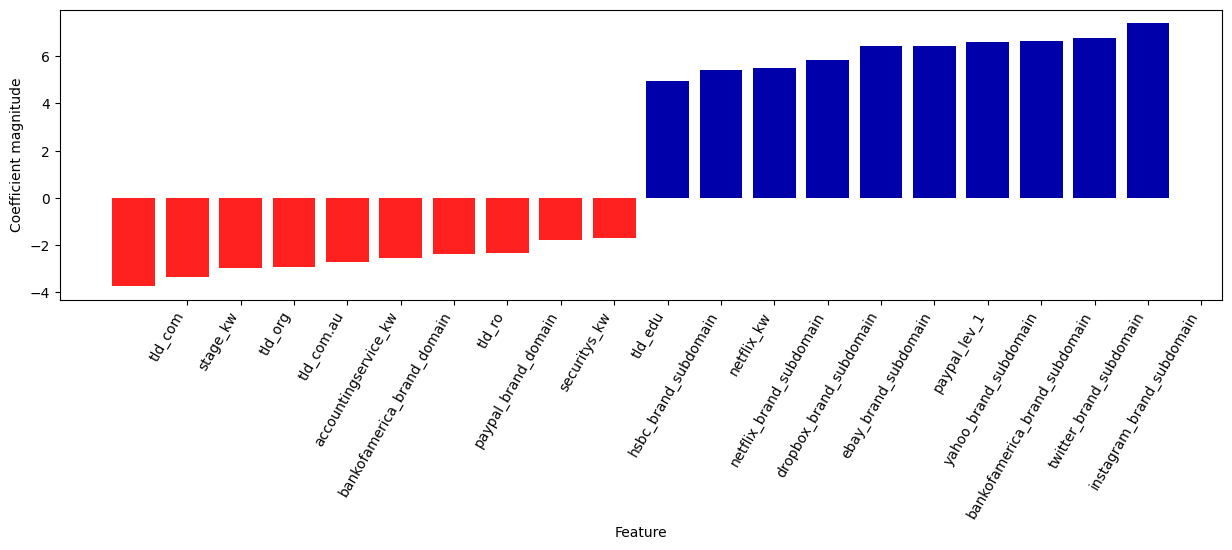

In [7]:
import mglearn
%matplotlib inline
import matplotlib.pyplot as plt

print("Number of features: {}".format(len(feature_vector)))

# Visualize the most important coefficients from the LogisticRegression model.
coef = classifier.coef_
mglearn.tools.visualize_coefficients(coef, feature_vector, n_top_features=10)

<h4>Precision / Recall:</h4> Precision shows how often the classifier is right when it cries wolf. Recall shows how many fish (no pun intended) the classifier caught out of all the fish in the pond. By default, the classifier assumes a malicious threshold of 0.5 on a scale of 0 to 1. This chart (and the subsequent TPR vs FPR chart) shows how these metrics change when increasing or decreasing the malicious threshold.<br>

Precision: 0.986
Recall: 0.988
Threshold: 0.496


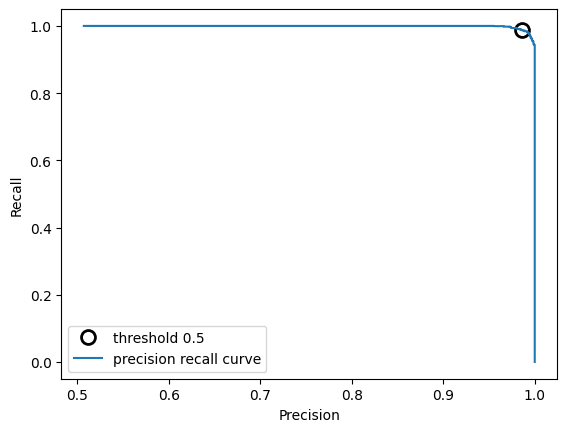

In [8]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, classifier.predict_proba(X_test)[:, 1])
close_zero = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold 0.5", fillstyle="none",
        c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
print("Precision: {:.3f}\nRecall: {:.3f}\nThreshold: {:.3f}".format(precision[close_zero], recall[close_zero], thresholds[close_zero]))

<h4>True Positive Rate (TPR) / False Positive Rate (FPR):</h4> Basically a summary of misclassifications from the classifier against the test set.<br>

TPR: 0.988
FPR: 0.014
Threshold: 0.496


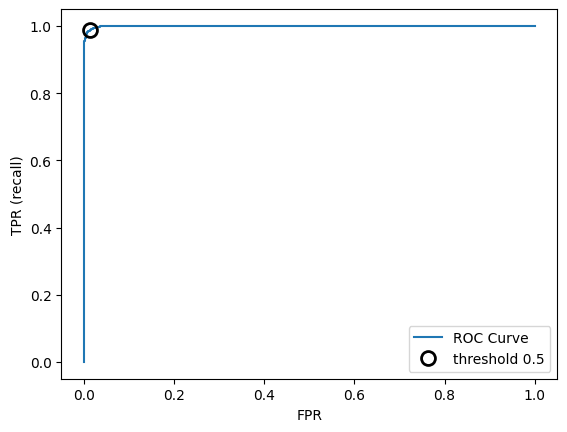

In [9]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold 0.5", fillstyle="none", c="k",
        mew=2)
plt.legend(loc=4)
print("TPR: {:.3f}\nFPR: {:.3f}\nThreshold: {:.3f}".format(tpr[close_zero], fpr[close_zero],
                                                                thresholds[close_zero]))

<h4>Classification Report:</h4> Shows a lot of the same metrics plus the f1-score (combination of precision and recall) as well as support (shows possible class imbalance from the training set.<br>

In [10]:
from sklearn.metrics import classification_report

predictions = classifier.predict_proba(X_test)[:, 1] > 0.5
print(classification_report(y_test, predictions, target_names=['Not Phishing', 'Phishing']))

              precision    recall  f1-score   support

Not Phishing       0.99      0.99      0.99      1411
    Phishing       0.99      0.99      0.99      1452

    accuracy                           0.99      2863
   macro avg       0.99      0.99      0.99      2863
weighted avg       0.99      0.99      0.99      2863



# 6. Test Classifier Against New Data

The metrics look great. The code snippet below shows how you can transform a list of any FQDNs you'd like, extract features, reindex the features against the feature vector from training, and make a prediction.

In [11]:
phish = PhishFeatures()    # We need the compute_features() method to evaluate new data.
LABEL_MAP = {0: "Not Phishing", 1: "Phishing"}

In [12]:
example_domains = [
    "paypal.com",
    "apple.com",
    "patternex.com",
    "support-apple.xyz",
    "paypall.com",
    "pavpal-verify.com"
]

# Compute features, and also note we need to provide the feature vector from when we
# trained the model earlier in this notebook.
features = phish.compute_features(example_domains)
prediction = classifier.predict_proba(features['values'])[:, 1] > 0.5
prediction_scores = classifier.predict_proba(features['values'])[:, 1]

for domain, classification, score in zip(example_domains, prediction, prediction_scores):
    print("[{}]\t{}\t{:.3f}".format(LABEL_MAP[classification], domain, score))

[Not Phishing]	paypal.com	0.008
[Not Phishing]	apple.com	0.003
[Not Phishing]	patternex.com	0.000
[Phishing]	support-apple.xyz	0.986
[Phishing]	paypall.com	0.833
[Phishing]	pavpal-verify.com	0.999


<div style="float: center; margin: 10px 10px 10px 10px"><img src="../images/fishwordgraph.png"></div>